In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [21]:
n = 100
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train
x_test = x_train[-10:]
x_train = x_train[:-10]

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.991666666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0197916666666695
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.999999999999999
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.998958333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0031250000000016
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.996875000000003
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0250000000000044
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9906250000000014
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.993750000000001
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.004166666666668
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0124999999999997
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.002083333333336
 |>  150
 [DEBUG] > 

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.993749999999998
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9989583333333334
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.992708333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0041666666666687
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.025000000000002
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.992708333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000018
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.993750000000003
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666676
 |>  150


In [22]:
x_train.shape

(260, 150, 1)

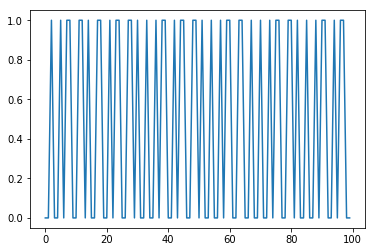

In [23]:
plt.plot(x_train[0,:100])

In [24]:
x_train.shape

(260, 150, 1)

In [25]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 150
input_shape

(150, 1)

In [26]:
output_shape

(150, 1)

In [27]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [28]:
k_reg = regularizers.l2(0.01) # 10e-5
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(0.01) # 10e-5

In [29]:
input_shape
# input_shape = (150,)
input_shape

(150, 1)

In [30]:
batch_size = 16
original_dim = 150
latent_dim = 2
intermediate_dim = 150
epsilon_std = 1.0

In [31]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [32]:
def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    y = encoder_input
    y = Reshape(input_shape[:1])(y) # Flatten() nees 3 dims
    h = Dense(intermediate_dim, activation='relu', name='encoder_h-')(y)
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, input_shape, intermediate_dim = 150):
    z = Input(shape=(latent_dim,), name='decoder_input-')
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h-')
    h = decoder_h(z)
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean-')
    x_decoded_mean = decoder_mean(h)
    h = Reshape(input_shape)(x_decoded_mean)
    decoder_output = h
    model = Model(inputs=z, outputs=decoder_output, name='decoder_model-')
    return model

In [87]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, input_shape)

vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
# vae = Model(encoder_input, decoder_model(z))
# vae = Model(encoder_input, decoder_output)
encoder_model.summary()
z_model.summary()
decoder_model.summary()
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 150)          0           encoder_input-[0][0]             
__________________________________________________________________________________________________
encoder_h- (Dense)              (None, 150)          22650       reshape_13[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            302         encoder_h-[0][0]                 
__________________________________________________________________________________________________
z_log_var 

In [88]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    xent_loss = K.binary_crossentropy(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)
    return xent_loss + kl_loss

In [103]:
metrics = ['accuracy','mse','mae']
# loss = 'binary_crossentropy'#  sparse_categorical_crossentropy
loss = lambda y_true, y_pred: vae_loss(y_true, y_pred, z_mean, z_log_var)
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [104]:
# # xent_loss = original_dim * keras.metrics.binary_crossentropy(vae_input, vae_output)
# # xent_loss = keras.metrics.binary_crossentropy(vae_input, vae_output)
# xent_loss = np.prod(input_shape) * keras.metrics.binary_crossentropy(vae_input, vae_output)
# # kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)

# vae_loss = K.mean(xent_loss + kl_loss)

# vae.add_loss(vae_loss)
# vae.compile(optimizer='rmsprop', metrics=['binary_accuracy','mae'])

In [105]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(260, 150, 1)

In [106]:
epochs = 100
m = 50
vs = 1/6
shuffle = True
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = vae.fit(x_train[:m], x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks, shuffle=shuffle)
# history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 41 samples, validate on 9 samples
Epoch 1/100
41/41 [==============================] - 0s 6ms/step - loss: 0.8351 - acc: 0.5268 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4982 - val_loss: 0.7823 - val_acc: 0.5659 - val_mean_squared_error: 0.2455 - val_mean_absolute_error: 0.4942
Epoch 2/100
41/41 [==============================] - 0s 298us/step - loss: 0.7559 - acc: 0.5990 - mean_squared_error: 0.2444 - mean_absolute_error: 0.4932 - val_loss: 0.7795 - val_acc: 0.6133 - val_mean_squared_error: 0.2452 - val_mean_absolute_error: 0.4945
Epoch 3/100
41/41 [==============================] - 0s 303us/step - loss: 0.6944 - acc: 0.6421 - mean_squared_error: 0.2407 - mean_absolute_error: 0.4888 - val_loss: 0.7628 - val_acc: 0.6578 - val_mean_squared_error: 0.2396 - val_mean_absolute_error: 0.4876
Epoch 4/100
41/41 [==============================] - 0s 310us/step - loss: 0.6805 - acc: 0.6698 - mean_squared_error: 0.2383 - mean_absolute_error: 0.4862 - val_loss: 0.7547 - val_ac

41/41 [==============================] - 0s 562us/step - loss: 0.6066 - acc: 0.7102 - mean_squared_error: 0.2041 - mean_absolute_error: 0.4101 - val_loss: 0.7062 - val_acc: 0.7044 - val_mean_squared_error: 0.2107 - val_mean_absolute_error: 0.4334
Epoch 33/100
41/41 [==============================] - 0s 324us/step - loss: 0.6107 - acc: 0.7102 - mean_squared_error: 0.2048 - mean_absolute_error: 0.4130 - val_loss: 0.7469 - val_acc: 0.7044 - val_mean_squared_error: 0.2167 - val_mean_absolute_error: 0.4331
Epoch 34/100
41/41 [==============================] - 0s 601us/step - loss: 0.6095 - acc: 0.7099 - mean_squared_error: 0.2037 - mean_absolute_error: 0.4146 - val_loss: 0.6816 - val_acc: 0.7044 - val_mean_squared_error: 0.2137 - val_mean_absolute_error: 0.4192
Epoch 35/100
41/41 [==============================] - 0s 450us/step - loss: 0.6069 - acc: 0.7104 - mean_squared_error: 0.2049 - mean_absolute_error: 0.4187 - val_loss: 0.7017 - val_acc: 0.7044 - val_mean_squared_error: 0.2153 - val_m

41/41 [==============================] - 0s 409us/step - loss: 0.5917 - acc: 0.7104 - mean_squared_error: 0.1998 - mean_absolute_error: 0.4043 - val_loss: 0.6610 - val_acc: 0.7044 - val_mean_squared_error: 0.2101 - val_mean_absolute_error: 0.4127
Epoch 64/100
41/41 [==============================] - 0s 490us/step - loss: 0.5962 - acc: 0.7104 - mean_squared_error: 0.1999 - mean_absolute_error: 0.4045 - val_loss: 0.6714 - val_acc: 0.7044 - val_mean_squared_error: 0.2099 - val_mean_absolute_error: 0.4067
Epoch 65/100
41/41 [==============================] - 0s 402us/step - loss: 0.5963 - acc: 0.7104 - mean_squared_error: 0.2020 - mean_absolute_error: 0.4065 - val_loss: 0.6727 - val_acc: 0.7044 - val_mean_squared_error: 0.2117 - val_mean_absolute_error: 0.4144
Epoch 66/100
41/41 [==============================] - 0s 564us/step - loss: 0.6007 - acc: 0.7104 - mean_squared_error: 0.2038 - mean_absolute_error: 0.4014 - val_loss: 0.7186 - val_acc: 0.7044 - val_mean_squared_error: 0.2140 - val_m

41/41 [==============================] - 0s 353us/step - loss: 0.5997 - acc: 0.7106 - mean_squared_error: 0.2022 - mean_absolute_error: 0.4047 - val_loss: 0.6828 - val_acc: 0.7044 - val_mean_squared_error: 0.2177 - val_mean_absolute_error: 0.4028
Epoch 95/100
41/41 [==============================] - 0s 389us/step - loss: 0.6011 - acc: 0.7104 - mean_squared_error: 0.2027 - mean_absolute_error: 0.4033 - val_loss: 0.6831 - val_acc: 0.7044 - val_mean_squared_error: 0.2145 - val_mean_absolute_error: 0.4161
Epoch 96/100
41/41 [==============================] - 0s 377us/step - loss: 0.5996 - acc: 0.7104 - mean_squared_error: 0.2025 - mean_absolute_error: 0.4028 - val_loss: 0.6793 - val_acc: 0.7044 - val_mean_squared_error: 0.2153 - val_mean_absolute_error: 0.4164
Epoch 97/100
41/41 [==============================] - 0s 351us/step - loss: 0.5961 - acc: 0.7104 - mean_squared_error: 0.2016 - mean_absolute_error: 0.4024 - val_loss: 0.7078 - val_acc: 0.7044 - val_mean_squared_error: 0.2226 - val_m

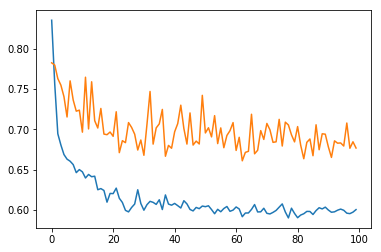

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

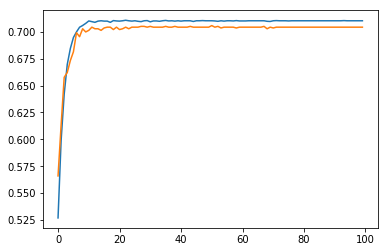

In [109]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

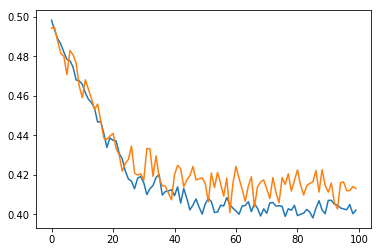

In [110]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [108]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'acc', 'mean_squared_error', 'mean_absolute_error'])

In [95]:
# plot_model(vae, to_file='model.png')

In [96]:
generator = decoder_model # decoder_model(z)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input- (InputLayer)  (None, 2)                 0         
_________________________________________________________________
decoder_h- (Dense)           (None, 150)               450       
_________________________________________________________________
decoder_mean- (Dense)        (None, 150)               22650     
_________________________________________________________________
reshape_14 (Reshape)         (None, 150, 1)            0         
Total params: 23,100
Trainable params: 23,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [ ]:
plt.plot(x_train[0,:100,:])

In [ ]:
result.shape

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)